In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import env
import numpy as np
import scipy.stats as stats

import wrangle_zillow

pd.set_option('display.max_rows', 100)

In [2]:
df = wrangle_zillow.acquire()

Reading from local CSV...


/var/folders/zb/3lg9b5xn3831bhkh23bd5bs00000gn/T/ipykernel_40517/3973466862.py:1: DtypeWarning: Columns (65) have mixed types.Specify dtype option on import or set low_memory=False.
  df = wrangle_zillow.acquire()


In [3]:
df = wrangle_zillow.prepare(df)

In [4]:
df = wrangle_zillow.handle_missing_values(df, .9, 1)

In [5]:
train, test, validate = wrangle_zillow.train_test_validate_split(df)

train	 n = 29366
test	 n = 10489
validate n = 12586


In [6]:
quant_cols = [col for col in df.columns if ((df[col].dtype != 'object') 
                                             & (len(df[col].unique()) > 10) 
                                             & ('regionid' not in col) 
                                             & ('census' not in col))]

train, validate, test = wrangle_zillow.remove_outliers(train, validate, test, 1.5, quant_cols)

train	 n = 23814
test	 n = 8536
validate n = 10191


/Users/bfs7/codeup-data-science/clustering-exercises/wrangle_zillow.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['outlier'] = False
/Users/bfs7/codeup-data-science/clustering-exercises/wrangle_zillow.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['outlier'] = np.where(((test[col] < lower_bound) | (test[col] > upper_bound)) & (test.outlier == False), True, test.outlier)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52441 entries, 0 to 77578
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bathroomcnt                52441 non-null  float64
 1   bedroomcnt                 52441 non-null  float64
 2   fips                       52441 non-null  float64
 3   fireplacecnt               52441 non-null  float64
 4   garagecarcnt               52441 non-null  float64
 5   garagetotalsqft            52441 non-null  float64
 6   hashottuborspa             52441 non-null  float64
 7   latitude                   52441 non-null  float64
 8   longitude                  52441 non-null  float64
 9   poolcnt                    52441 non-null  float64
 10  propertycountylandusecode  52441 non-null  object 
 11  regionidcounty             52441 non-null  float64
 12  roomcnt                    52441 non-null  float64
 13  threequarterbathnbr        52441 non-null  flo

#### 1. Does logerror differ across counties (fips)?



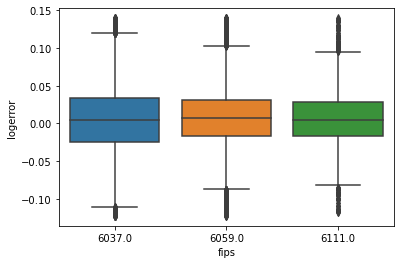

In [8]:
# visualize
sns.boxplot(data=train, x='fips', y='logerror')
plt.show()

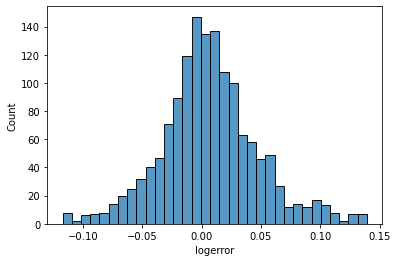

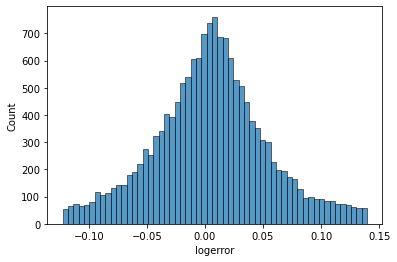

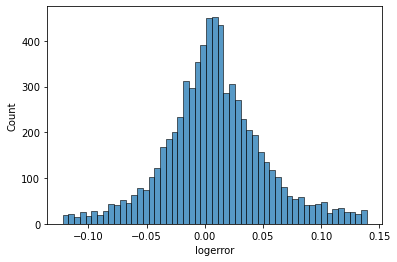

In [9]:
# verify assumptions: normal distribution
for fips_code in train.fips.unique():
    county = train[train.fips == fips_code]
    sns.histplot(county.logerror)
    plt.show()

In [10]:
county1 = df[df.fips == df.fips.unique()[0]]
county2 = df[df.fips == df.fips.unique()[1]]
county3 = df[df.fips == df.fips.unique()[2]]

alpha = .05
stat, p = stats.levene(county1.logerror, county2.logerror, county3.logerror)
if p < alpha:
    print('equal variances')
else: print('unequal variances')

equal variances


In [11]:
alpha = .05
stat, p = stats.f_oneway(county1.logerror, county2.logerror, county3.logerror)
stat, p

(20.039243491788056, 1.9970607325378107e-09)

In [12]:
if p < alpha:
    print('reject H0')
else: print('fail to reject H0')

reject H0


We reject the null hypothesis and proceed under the assumption that there is a difference in logerror among the three counties in our dataset

#### 2. Does logerror differ for properties that have garages vs. those that don't?

In [13]:
# get the data
garages = train[train.has_garage == 1]
no_garages = train[train.has_garage == 0]

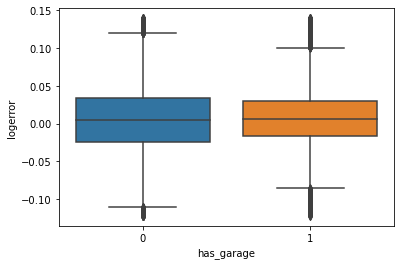

In [14]:
# visualize:
sns.boxplot(data=train, 
            x='has_garage',
            y='logerror')
plt.show()

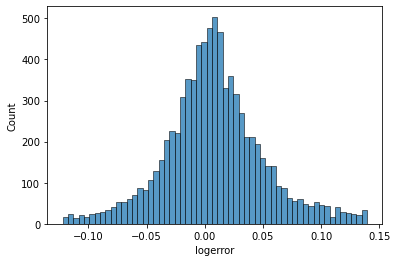

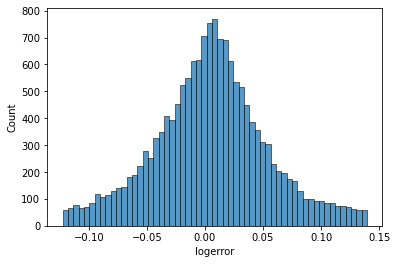

In [15]:
# verify assumptions: normal distribution
for subset in [garages, no_garages]:
    sns.histplot(subset.logerror)
    plt.show()

In [16]:
# verify assumptions: equal variances:
alpha = .05
stat, p = stats.levene(garages.logerror, no_garages.logerror)
if p < alpha:
    print('equal variances')
else: print('unequal variances')

equal variances


In [17]:
# perform the test
alpha = .05
t, p = stats.ttest_ind(garages.logerror, no_garages.logerror)
stat, p

(188.86567026470382, 4.084804311036769e-06)

In [18]:
if p < alpha:
    print('reject H0')
else: print('fail to reject H0')

reject H0


We reject the null hypothesis and proceed under the assumption that there is a difference in logerror for properties with garages compared to those without

#### 3. Does logerror differ for properties that have pools vs those that don't

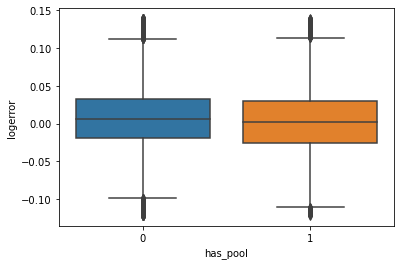

In [19]:
# visualize
sns.boxplot(data=train, x='has_pool', y='logerror')
plt.show()

In [20]:
# get data
pools = train[train.has_pool == 1]
no_pools = train[train.has_pool == 0]

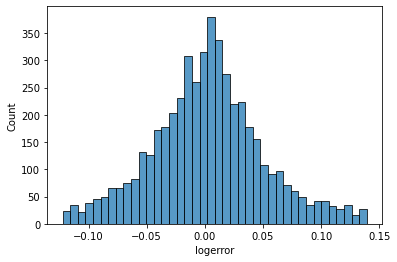

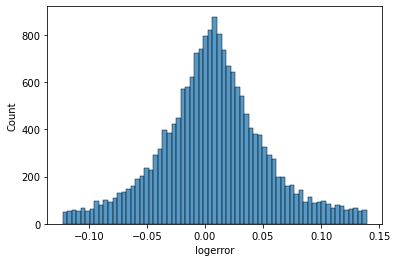

In [21]:
# verify assumptions: normal distribution
for subset in [pools, no_pools]:
    sns.histplot(subset.logerror)
    plt.show()

In [22]:
# verify assumptions: equal variances:
alpha = .05
stat, p = stats.levene(pools.logerror, no_pools.logerror)
if p < alpha:
    print('equal variances')
else: print('unequal variances')

equal variances


In [23]:
# perform the test
alpha = .05
t, p = stats.ttest_ind(pools.logerror, no_pools.logerror)
stat, p

(6.246481881528061, 2.7099346756423845e-09)

In [24]:
if p < alpha:
    print('reject H0')
else: print('fail to reject H0')

reject H0


We reject the null hypothesis and proceed under the assumption that there is a difference in logerror for properties with pools compared to those without

#### 4. Does logerror differ for properties that have a hot tub or spa vs those that don't?


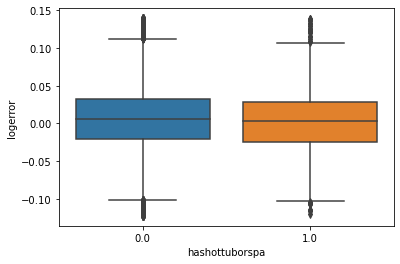

In [25]:
# visualize
sns.boxplot(data=train, x='hashottuborspa', y='logerror')
plt.show()

In [26]:
# get the data
hottubs = train[train.hashottuborspa == 1]
no_hottubs = train[train.hashottuborspa == 0]

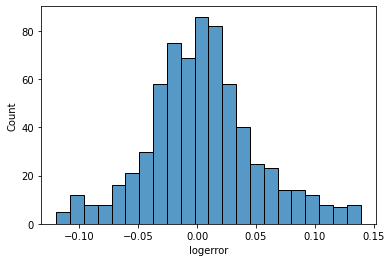

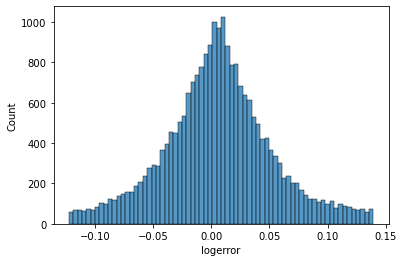

In [27]:
# verify assumptions: normal distribution
for subset in [hottubs, no_hottubs]:
    sns.histplot(subset.logerror)
    plt.show()

In [28]:
# verify assumptions: equal variances:
alpha = .05
stat, p = stats.levene(hottubs.logerror, no_hottubs.logerror)
if p < alpha:
    print('equal variances')
else: print('unequal variances')

unequal variances


In [29]:
# perform the test (unequal variances >> non-parametric test == Mann-Whitney)
alpha = .05
stat, p = stats.mannwhitneyu(hottubs.logerror, no_hottubs.logerror)
stat, p

(7631071.0, 0.2060613540215025)

In [30]:
if p < alpha:
    print('reject H0')
else: print('fail to reject H0')

fail to reject H0


We fail to reject the null hypothesis and we proceed under the assumption that:
    there is no difference in logerror for properties with and without hot tubs / spas

#### 5. Is there a difference in logerror for properties with fireplaces vs those without?

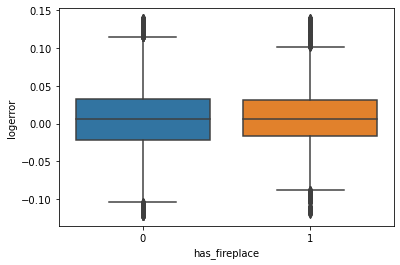

In [31]:
# visualize:
sns.boxplot(data=train, 
            x='has_fireplace',
            y='logerror')
plt.show()

In [32]:
# get the data
fireplaces = train[train.has_fireplace == 1]
no_fireplaces = train[train.has_fireplace == 0]

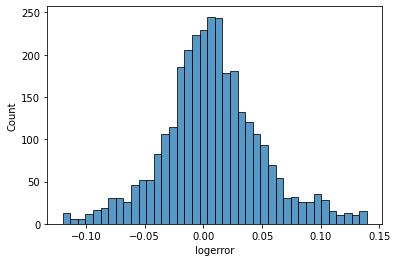

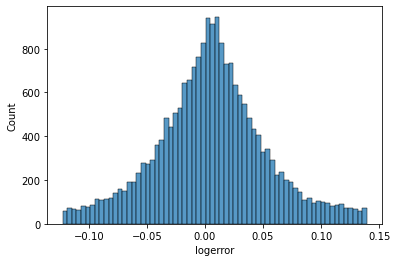

In [33]:
# verify assumptions: normal distribution
for subset in [fireplaces, no_fireplaces]:
    sns.histplot(subset.logerror)
    plt.show()

In [34]:
# verify assumptions: equal variances:
alpha = .05
stat, p = stats.levene(hottubs.logerror, no_hottubs.logerror)
if p < alpha:
    print('equal variances')
else: print('unequal variances')

unequal variances


In [35]:
# perform the test (unequal variances >> non-parametric test == Mann-Whitney)
alpha = .05
stat, p = stats.mannwhitneyu(fireplaces.logerror, no_fireplaces.logerror)
stat, p

(32922818.0, 0.06980066312999443)

In [36]:
if p < alpha:
    print('reject H0')
else: print('fail to reject H0')

fail to reject H0


We fail to reject the null hypothesis and proceed under the assumption that there is no difference in logerror for properties with fireplaces vs those without. 

### BONUS: Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error. 

In [37]:
df = wrangle_zillow.acquire()

Reading from local CSV...


/var/folders/zb/3lg9b5xn3831bhkh23bd5bs00000gn/T/ipykernel_40517/3973466862.py:1: DtypeWarning: Columns (65) have mixed types.Specify dtype option on import or set low_memory=False.
  df = wrangle_zillow.acquire()


In [38]:
df = df[['regionidzip', 'logerror']]
df = df.dropna()

In [39]:
train, test, validate = wrangle_zillow.train_test_validate_split(df)

train	 n = 43416
test	 n = 15506
validate n = 18607


In [40]:
alpha = .05
zipcode_list = [] # for storing zipcodes whose errors are significantly different from average
for zipcode in train.regionidzip.unique():
    subset = df[df.regionidzip == zipcode]
    _, p = stats.ttest_1samp(subset.logerror, train.logerror.mean())
    if p < .05:
        zipcode_list.append(zipcode)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [41]:
# zipcodes where the logerror is significantly different that the overall error:
for zipcode in zipcode_list:
    print(int(zipcode))

96339
96996
96387
96244
96974
97039
97068
96349
96104
95984
96957
96047
96190
96124
96095
96137
96492
96117
96241
96022
96378
96951
96993
96356
96294
96985
96336
96197
96415
96020
97064
96325
96171
96475
96465
96217
96026
96097
96120
97051
95989
96426
97298
96218
96152
96327
96043
96517
96228
96007
96293
96379
96216
96508
96107
96280
96326
96103
96946
96004
96038
96245
96478
